In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, avg, to_timestamp, hour, date_format, month, year, when, mean, expr, element_at
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline


In [2]:
from dotenv import load_dotenv
import os
load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")


In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("US Accidents") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", key_filepath) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/10 00:53:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:

# Read Parquet files from GCS
parquet_files = [
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2016/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2017/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2018/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2019/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2020/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2021/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2022/933c14c388864f19a17c514e311a69b1-0.parquet",
                "gs://us-accidents-bucket/us_accidents_data/Start_Year=2023/933c14c388864f19a17c514e311a69b1-0.parquet"
                ]

df_list = [spark.read.option("header", "true").option("inferSchema", "true").parquet(file) for file in parquet_files]

merged_df = df_list[0]
for df in df_list[1:]:
    merged_df = merged_df.unionAll(df)

In [5]:
merged_df.show()

24/04/30 23:00:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-------+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+--------------------+------------+----------+-----+-------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+
|  ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|Distance(mi)|         Description|              Street|        City|    County|State|Country|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|
+----+-------+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+--------------------+------------+----------+-----+-------+--------------+-------------+-----------+

# Cleaning the data

### Steps:
> Removing unimportnant columns

> Renaming the columns

> Convert the values of the columns into easy handled values

In [5]:
from pyspark.sql.functions import to_timestamp

# Convert "Start_Time" and "End_Time" columns to datetime format
merged_df = merged_df.withColumn("Start_Time", to_timestamp(merged_df["Start_Time"], "yyyy-MM-dd HH:mm:ss"))
merged_df = merged_df.withColumn("End_Time", to_timestamp(merged_df["End_Time"], "yyyy-MM-dd HH:mm:ss"))


In [6]:

# Convert "Severity" column from string to integer
merged_df = merged_df.withColumn("Severity", merged_df["Severity"].cast(IntegerType()))


In [7]:
# TODO: If the rows that have at least one null value remove them, and if they are large number 
# replace the null with the average of its column
merged_df = merged_df.dropna()

In [39]:
merged_df.count()

5656839

## We have dropped about 2 millions records because of nulls :)

In [8]:
# Create a new column called Duration = End_Time - Start_Time
# To indicate the duration of the accident
from pyspark.sql.functions import col, unix_timestamp

# Convert "Start_Time" and "End_Time" columns to Unix timestamp (seconds since the epoch)
merged_df = merged_df.withColumn("Start_Time_unix", unix_timestamp("Start_Time"))
merged_df = merged_df.withColumn("End_Time_unix", unix_timestamp("End_Time"))

# Calculate the duration (in seconds)
merged_df = merged_df.withColumn("Duration", col("End_Time_unix") - col("Start_Time_unix"))


In [9]:
# Add columns for start_time
merged_df = merged_df.withColumn('Hour_Of_Acc', hour(merged_df['Start_Time']))
merged_df = merged_df.withColumn('Day_Of_Acc', date_format(merged_df['Start_Time'], 'EEEE'))
merged_df = merged_df.withColumn('Month_Of_Acc', month(merged_df['Start_Time']))

In [10]:
# Use 'when' function to assign temperature categories based on the bins
temperature_category_column = when(merged_df['Temperature(F)'] <= 50, 'Cold') \
    .when((merged_df['Temperature(F)'] > 50) & (merged_df['Temperature(F)'] <= 75), 'Moderate') \
    .otherwise('Warm')

# Add the temperature category column to the DataFrame
merged_df = merged_df.withColumn('Temperature_Category', temperature_category_column)

In [11]:
# Convert "Distance(mi)" column from miles to meters
merged_df = merged_df.withColumn("Distance(m)", col("Distance(mi)") * 1609.34)

In [12]:
# Drop unnecessary or redundant columns

# List of column names to drop
columns_to_drop = ['Country', 'Start_Time', 'End_Time', 'Distance(mi)', 'Start_Time_unix', 'End_Time_unix']

# Drop the unimportant columns
merged_df = merged_df.drop(*columns_to_drop)



In [37]:
merged_df.show()

+----+-------+--------+---------+------------------+--------------------+--------------------+------------+----------+-----+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+--------+-------+-------+---------------+--------------+--------------+--------+-----------+----------+------------+--------------------+-----------+
|  ID| Source|Severity|Start_Lat|         Start_Lng|         Description|              Street|        City|    County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Weather_Condition|Crossing|Railway|Station|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Duration|Hour_Of_Acc|Day_Of_Acc|Month_Of_Acc|Temperature_Category|Distance(m)|
+----+-------+--------+---------+------------------+--------------------+--------------------+------------+----------+-----+--------------+-------------+-----------+------------+--------------+--------------+--------

In [42]:
merged_df.columns

['ID',
 'Source',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'Description',
 'Street',
 'City',
 'County',
 'State',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Weather_Condition',
 'Crossing',
 'Railway',
 'Station',
 'Traffic_Calming',
 'Traffic_Signal',
 'Sunrise_Sunset',
 'Distance(m)',
 'Start_Time_unix',
 'End_Time_unix',
 'Duration']

# Predictive Analytics

1. [Regression]➔ Predicting accident Duration as indicator of impact on
traffic flow.

2. [classification]➔ Predicting the severity of an accident based on the
factors involved.

### Based on the EDA phase we will use the following features in our model:
- Start_Lat
- Start_Lng
- Duration
- Hour_Of_Acc
- Day_Of_Acc
- Month_Of_Acc
- Temperature
- Distance
- State
- Crossing
- Railway
- Traffic_Calming
- Traffic_Signal
- Sunrise_Sunset
- Wind_Direction
- Wind_Speed(mph)


### Note: 

The severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay).

In [13]:

columns_to_keep = [
    "Start_Lat","Start_Lng","Duration",
    "Hour_Of_Acc","Day_Of_Acc","Month_Of_Acc",
    "Temperature(F)","Sunrise_Sunset","Distance(m)",
    "State", "City", "Crossing","Railway",
    'Wind_Direction', 'Wind_Speed(mph)',
    "Traffic_Calming", "Traffic_Signal", "Severity"
]

# Selecting only the desired columns
data_df = merged_df.select(columns_to_keep)

# Showing the resulting DataFrame
data_df.show(1)

24/05/10 00:53:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+----------+--------+-----------+----------+------------+--------------+--------------+-----------+-----+------------+--------+-------+--------------+---------------+---------------+--------------+--------+
|Start_Lat| Start_Lng|Duration|Hour_Of_Acc|Day_Of_Acc|Month_Of_Acc|Temperature(F)|Sunrise_Sunset|Distance(m)|State|        City|Crossing|Railway|Wind_Direction|Wind_Speed(mph)|Traffic_Calming|Traffic_Signal|Severity|
+---------+----------+--------+-----------+----------+------------+--------------+--------------+-----------+-----+------------+--------+-------+--------------+---------------+---------------+--------------+--------+
|39.063148|-84.032608|    1800|          6|    Monday|           2|          36.0|         Night|    16.0934|   OH|Williamsburg|   false|  false|            SW|            3.5|          false|          true|       2|
+---------+----------+--------+-----------+----------+------------+--------------+--------------+-----------+-----+------------+----

## 1. Logistic Regression

➔ Predicting the severity of an accident based on the factors

In [14]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

In [15]:
# Convert string columns to numerical representations
string_columns = ["Day_Of_Acc", "Sunrise_Sunset", "State", "City", "Wind_Direction"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data_df) for column in string_columns]

In [16]:
# Assemble features
numerical_columns = ["Duration", "Hour_Of_Acc", "Month_Of_Acc", "Temperature(F)", "Distance(m)"]
boolean_columns = ["Crossing", "Railway", "Traffic_Calming", "Traffic_Signal"]
assembler = VectorAssembler(inputCols=numerical_columns + [column+"_index" for column in string_columns] + boolean_columns, outputCol="features")

In [17]:
# Split the data into training and testing sets
(training_data, test_data) = data_df.randomSplit([0.75, 0.25], seed=42)

# Instantiate logistic regression model
lgr = LogisticRegression(featuresCol="features", labelCol="Severity")

In [ ]:
# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, lgr])

# Train the model
model = pipeline.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

In [19]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8408217891358007


In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score:", f1_score)


F1 Score: 0.7685677937765466


### 1.2 Logistic Regression with Map Reduce

In [17]:
# Create a Pipeline to chain the StringIndexer transformations
indexer_pipeline = Pipeline(stages=indexers)

# Use the Pipeline to transform the data
stages = indexer_pipeline.fit(data_df).transform(data_df)

# Combine StringIndexer transformations using list comprehension
stages = data_df

for indexer in indexers:
  stages = indexer.transform(stages)

In [41]:
stages.show(1)

+---------+----------+--------+-----------+----------+------------+--------------+--------------+-----------+-----+------------+--------+-------+--------------+---------------+---------------+--------------+--------+----------------+--------------------+-----------+----------+--------------------+
|Start_Lat| Start_Lng|Duration|Hour_Of_Acc|Day_Of_Acc|Month_Of_Acc|Temperature(F)|Sunrise_Sunset|Distance(m)|State|        City|Crossing|Railway|Wind_Direction|Wind_Speed(mph)|Traffic_Calming|Traffic_Signal|Severity|Day_Of_Acc_index|Sunrise_Sunset_index|State_index|City_index|Wind_Direction_index|
+---------+----------+--------+-----------+----------+------------+--------------+--------------+-----------+-----+------------+--------+-------+--------------+---------------+---------------+--------------+--------+----------------+--------------------+-----------+----------+--------------------+
|39.063148|-84.032608|    1800|          6|    Monday|           2|          36.0|         Night|    16

In [18]:
new_data = stages.drop('Day_Of_Acc', 'Sunrise_Sunset', 'City', 'State', 'Wind_Direction')
new_data.show(1)

+---------+----------+--------+-----------+------------+--------------+-----------+--------+-------+---------------+---------------+--------------+--------+----------------+--------------------+-----------+----------+--------------------+
|Start_Lat| Start_Lng|Duration|Hour_Of_Acc|Month_Of_Acc|Temperature(F)|Distance(m)|Crossing|Railway|Wind_Speed(mph)|Traffic_Calming|Traffic_Signal|Severity|Day_Of_Acc_index|Sunrise_Sunset_index|State_index|City_index|Wind_Direction_index|
+---------+----------+--------+-----------+------------+--------------+-----------+--------+-------+---------------+---------------+--------------+--------+----------------+--------------------+-----------+----------+--------------------+
|39.063148|-84.032608|    1800|          6|           2|          36.0|    16.0934|   false|  false|            3.5|          false|          true|       2|             4.0|                 1.0|       18.0|     519.0|                 8.0|
+---------+----------+--------+-----------+-

In [19]:
# Split the data into training and testing sets
(training_data_mr, test_data_mr) = new_data.randomSplit([0.75, 0.25], seed=42)

In [20]:
from logistic_regression_mr import LogisticRegression

# 1. convert the data into rdd
training_data_mr = training_data_mr.rdd.map(lambda row: (row[0:12] + row[13:-1], row[12]))

In [21]:
print(training_data_mr.first())

((33.183228, -117.296371, 2673, 21, 12, 44.1, 16.0934, False, False, 4.6, False, False, 4.0, 1.0, 0.0, 376.0), 2)


In [22]:
learning_rate = 0.001  
num_iterations = 5   
model = LogisticRegression(learning_rate, num_iterations)

In [23]:
cost_history = model.fit(training_data_mr)

16


Iteration 0 => Cost: 39.814399


## 2. Linear Regression
➔ Predicting accident Duration as indicator of impact on traffic flow. 

In [34]:
lr_data_df = data_df

In [61]:
# Convert string columns to numerical representations
string_columns = ["Day_Of_Acc", "Sunrise_Sunset", "Wind_Direction"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(lr_data_df) for column in string_columns]
indexed_df = lr_data_df
for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)

# Assemble features
numerical_columns = ["Severity", "Hour_Of_Acc", "Month_Of_Acc", "Temperature(F)", "Distance(m)"]
boolean_columns = ["Crossing", "Railway", "Traffic_Calming", "Traffic_Signal"]
assembler = VectorAssembler(inputCols=numerical_columns + [column+"_index" for column in string_columns] + boolean_columns, outputCol="features")
indexed_df = assembler.transform(indexed_df)

# Split the data into training and testing sets
(training__lr_data, test_lr_data) = indexed_df.randomSplit([0.75, 0.25], seed=42)

In [62]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Duration", regParam=0.5)
lr_model = lr.fit(training__lr_data)

# Make predictions on the test data
predictions = lr_model.transform(test_lr_data)

In [63]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Duration", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 906596


In [64]:
# Define feature_cols
feature_cols = numerical_columns + [column+"_index" for column in string_columns] + boolean_columns

# Show some predictions
predictions.select("Duration", "prediction", *feature_cols).show()

+--------+------------------+--------+-----------+------------+--------------+-----------+----------------+--------------------+--------------------+--------+-------+---------------+--------------+
|Duration|        prediction|Severity|Hour_Of_Acc|Month_Of_Acc|Temperature(F)|Distance(m)|Day_Of_Acc_index|Sunrise_Sunset_index|Wind_Direction_index|Crossing|Railway|Traffic_Calming|Traffic_Signal|
+--------+------------------+--------+-----------+------------+--------------+-----------+----------------+--------------------+--------------------+--------+-------+---------------+--------------+
|    1800| 43095.00317027075|       3|         23|          12|          39.2|    16.0934|             6.0|                 1.0|                15.0|   false|  false|          false|         false|
|    2700|35048.282267715076|       2|         18|           7|          82.0|        0.0|             4.0|                 0.0|                 5.0|   false|  false|          false|         false|
|    2086|

## 3. Random Forest

In [65]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [112]:
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", maxBins=11730)

# Split the data into training and test sets
train_data, test_data = data_df.randomSplit([0.8, 0.2], seed=42)

In [113]:
# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train the model
model = pipeline.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

24/05/09 21:47:57 WARN DAGScheduler: Broadcasting large task binary with size 1201.4 KiB


24/05/09 21:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1327.5 KiB


24/05/09 21:49:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


24/05/09 21:49:38 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


24/05/09 21:50:08 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


In [114]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/05/09 21:50:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


Accuracy: 0.8406899831395097


In [115]:
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score:", f1_score)

24/05/09 21:51:50 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


F1 Score: 0.7680208605030131


## 4. Naive Bayes

In [18]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler

# Scale features to ensure nonnegative values
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Instantiate Naive Bayes model
nb = NaiveBayes(featuresCol="scaled_features", labelCol="Severity")

# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, nb])

# Train the model
model = pipeline.fit(training_data)

# Make predictions
predictions = model.transform(test_data)


In [19]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/05/09 23:11:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/09 23:11:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Accuracy: 0.011417897007984124


In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score:", f1_score)

F1 Score: 0.0002577932869698937


# 2. Descriptive Analytics

- ## Clustering

In the context of clustering accident locations based on latitude information, clusters represent groups of accident locations that have similar latitude coordinates.

When applying clustering algorithm like K-means to accident data, the algorithm partitions the accident locations into a predefined number of clusters, with each cluster representing a group of locations that are close to each other in terms of latitude and longitude.

The meaning of these clusters can vary depending on factors such as geographical characteristics, traffic patterns, road conditions, or other contextual information. However, generally, clusters can help identify areas where accidents are more concentrated

### 1. Preprocess

In [14]:
from pyspark.ml.feature import VectorAssembler

# Step 1: Preprocessing
# Select relevant features (latitude and longitude)
latlong_data = merged_df.select('Start_Lat', 'Start_Lng')

# Assemble features into a vector
assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng'], outputCol='features')
latlong_data = assembler.transform(latlong_data)

### 2. Choose the number of clusters

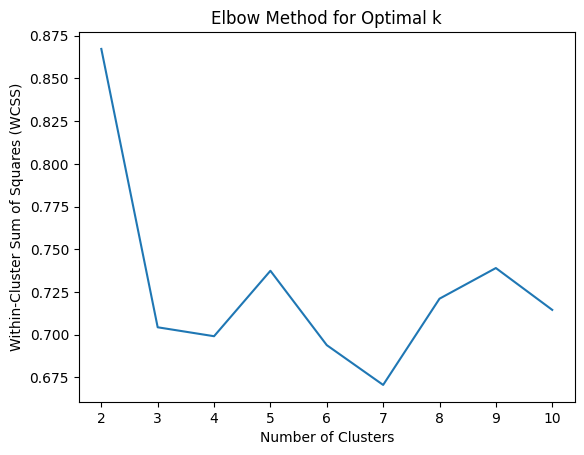

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Step 2: Choose the Number of Clusters

wcss = []

# Use the Elbow Method to determine the optimal number of clusters
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=42)
    model = kmeans.fit(latlong_data)
    predictions = model.transform(latlong_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    wcss.append(silhouette)

# Look for a point where the silhouette score stops increasing significantly with increasing k. This point typically resembles an elbow shape in the plot, hence the name "elbow method."
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [17]:
# Step 3: Apply KMeans with the chosen k
optimal_k = 9 # Choose the optimal number of clusters based on the plot
kmeans = KMeans(k=optimal_k, seed=42)
model = kmeans.fit(latlong_data)

# Get cluster centers
cluster_centers = model.clusterCenters()

/home/asaad/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


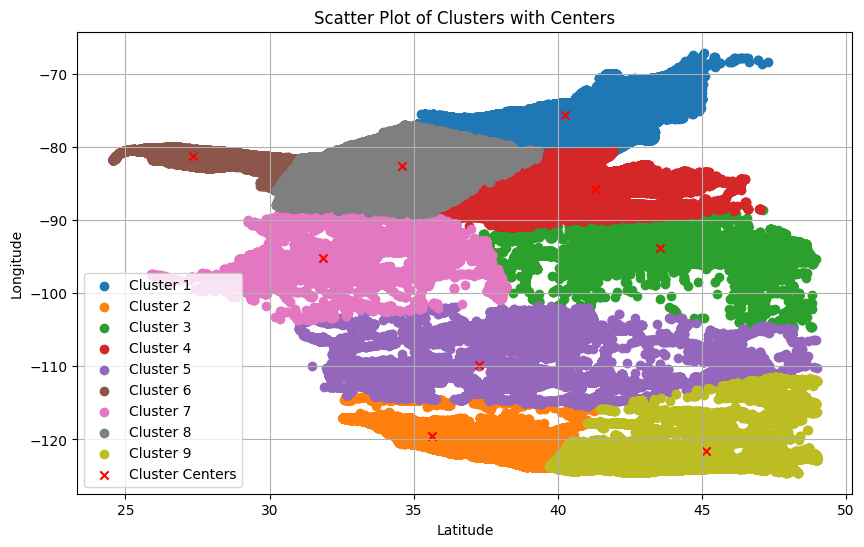

In [25]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert cluster_centers to Pandas DataFrame
centers_df = pd.DataFrame(cluster_centers, columns=['x', 'y'])

# Extract x and y coordinates of cluster centers
center_x = centers_df['x']
center_y = centers_df['y']

# Convert latlong_data to Pandas DataFrame
latlong_df = latlong_data.toPandas()

# Apply KMeans to latlong_data and get predictions
predictions = model.transform(latlong_data).select('prediction').collect()
predictions = [row['prediction'] for row in predictions]

# Convert predictions to a NumPy array for indexing
predictions = np.array(predictions)

# Plot the data points for each cluster
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_points = latlong_df[predictions == i]  # Extract data points for current cluster
    plt.scatter(cluster_points['Start_Lat'], cluster_points['Start_Lng'], label=f'Cluster {i+1}')

# Overlay cluster centers on the plot
plt.scatter(center_x, center_y, color='red', marker='x', label='Cluster Centers')

plt.title('Scatter Plot of Clusters with Centers')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid(True)
plt.show()


## Association Rules

In [26]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.fpm import FPGrowth

In [30]:
selected_columns = ['Weather_Condition', 'Crossing', 'Railway', 'Sunrise_Sunset', 'Day_Of_Acc', 'Severity']

df_selected = merged_df.select(selected_columns)

df_selected = df_selected.withColumn('Crossing', when(df_selected['Crossing'], 'crossing').otherwise('not crossing'))

df_selected = df_selected.withColumn('Railway', when(df_selected['Railway'], 'railway').otherwise('not railway'))
df_selected.show(1)




+-----------------+------------+-----------+--------------+----------+--------+
|Weather_Condition|    Crossing|    Railway|Sunrise_Sunset|Day_Of_Acc|Severity|
+-----------------+------------+-----------+--------------+----------+--------+
|         Overcast|not crossing|not railway|         Night|    Monday|       2|
+-----------------+------------+-----------+--------------+----------+--------+
only showing top 1 row



In [31]:
# Indexing categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_selected) for column in selected_columns]
indexed_df = df_selected
for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)

In [36]:
indexed_df.show(1)

+-----------------------+--------------+-------------+--------------------+----------------+--------------+
|Weather_Condition_index|Crossing_index|Railway_index|Sunrise_Sunset_index|Day_Of_Acc_index|Severity_index|
+-----------------------+--------------+-------------+--------------------+----------------+--------------+
|                    7.0|           0.0|          0.0|                 1.0|             4.0|           0.0|
+-----------------------+--------------+-------------+--------------------+----------------+--------------+
only showing top 1 row



In [32]:
# Selecting indexed columns
indexed_columns = [column+"_index" for column in selected_columns]
indexed_df = indexed_df.select(indexed_columns)

In [37]:
indexed_df.show(1)

+-----------------------+--------------+-------------+--------------------+----------------+--------------+
|Weather_Condition_index|Crossing_index|Railway_index|Sunrise_Sunset_index|Day_Of_Acc_index|Severity_index|
+-----------------------+--------------+-------------+--------------------+----------------+--------------+
|                    7.0|           0.0|          0.0|                 1.0|             4.0|           0.0|
+-----------------------+--------------+-------------+--------------------+----------------+--------------+
only showing top 1 row



In [ ]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import array

# Combine the columns into an array
combined_col = array('Weather_Condition_index', 'Crossing_index', 'Railway_index', 'Sunrise_Sunset_index', 'Day_Of_Acc_index', 'Severity_index')

# Generating frequent itemsets using FPGrowth
fp_growth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.5)
model = fp_growth.fit(indexed_df.withColumn("items", combined_col))
